In [88]:
import time

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# train, test, validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier



# scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

# decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

# feature engineering
from sklearn.preprocessing import PolynomialFeatures

# feature selection
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

In [89]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
combine = [train_df, test_df]

----
# modify features

## make ticket length feature
https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

In [90]:
train_df['Ticket_Len'] = train_df['Ticket'].apply(lambda x: len(x))
test_df['Ticket_Len'] = test_df['Ticket'].apply(lambda x: len(x))
combine = [train_df, test_df]

## make Cabin First character feature

In [91]:
train_df["Cabin_Letter"] = train_df["Cabin"].fillna('0').apply(lambda x: x[0])
test_df["Cabin_Letter"] = test_df["Cabin"].fillna('0').apply(lambda x: x[0])
combine = [train_df, test_df]

### make dummy variable for Cabin_Letter

In [92]:
train_test_df = pd.concat((train_df, test_df))

print(train_test_df.shape)

# apply get_dummies for Cabin_Letter
train_test_df = pd.get_dummies(train_test_df, columns=["Cabin_Letter"])

#train_test_df.head()
train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

# drop added Survived column from test_df
test_df = test_df.drop("Survived", axis=1)
print(train_df.shape, test_df.shape)

combine = [train_df, test_df]

(1309, 14)
(891, 22) (418, 21)


## make CabinBool feature
**I think the idea here is that people with recorded cabin numbers are of higher socioeconomic class, and thus more likely to survive. **
https://www.kaggle.com/nadintamer/titanic-survival-predictions-beginner

- I tried it
  - but gradient boosting result became worse. from 0.79904 to 0.77990
  - more than cabinbool is necessary? should i use first letter of cabin name?

**CabinBool is inclueded in Cabin letter and cabin number**
**no need to use**

## make Cabin number feature
https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

In [93]:
for i in [train_df, test_df]:
    i['Cabin_num1'] = i['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
    i['Cabin_num1'].replace('an', np.NaN, inplace = True)
    i['Cabin_num1'] = i['Cabin_num1'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)
    i['Cabin_num'] = pd.qcut(train_df['Cabin_num1'], 3)
    i['Cabin_num'] = i['Cabin_num'].cat.add_categories(["nan_category"])
    i['Cabin_num'] = i['Cabin_num'].fillna("nan_category")

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Program Files\Anaconda3\lib\site-packages\pandas\core\generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [94]:
train_df = pd.concat((train_df, pd.get_dummies(train_df['Cabin_num'], prefix='Cabin_num')), axis = 1)
test_df = pd.concat((test_df, pd.get_dummies(test_df['Cabin_num'], prefix='Cabin_num')), axis = 1)

In [95]:
del train_df['Cabin_num']
del test_df['Cabin_num']
del train_df['Cabin_num1']
del test_df['Cabin_num1']

**duplicate feature. delete one of these**

In [96]:
train_df = train_df.drop("Cabin_Letter_0", axis=1)
test_df = test_df.drop("Cabin_Letter_0", axis=1)
combine = [train_df, test_df]

## del Ticket, Cabin columns

In [97]:
# del Ticket, Cabin columns
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

## add title

In [98]:
# add title
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

## make name length feature

In [99]:
train_df['Name_Len'] = train_df['Name'].apply(lambda x: len(x))
test_df['Name_Len'] = test_df['Name'].apply(lambda x: len(x))
combine = [train_df, test_df]

## map value to Sex 

In [100]:
for dataset in combine:
    dataset["Sex"] = dataset["Sex"].map({'female':1, 'male':0}).astype(int)

## make Age_Null_Flag if the Age is nulll

In [101]:
train_df['Age_Null_Flag'] = train_df['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
test_df['Age_Null_Flag'] = test_df['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
combine = [train_df, test_df]

## fill na of Age

options

- by Sex and Pclass
- by Title and Pclass

### by Sex and Pclass

### fill nan of Age by Title and Pclass
https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

There is mistake in the original notebook.
test_df was filled by train_df.
So I modified.

In [102]:
train_test_df = pd.concat((train_df, test_df))
groupedAge_train_test = train_test_df.groupby(['Title', 'Pclass'])['Age']
train_test_df.Age = groupedAge_train_test.transform(lambda x:x.fillna(x.mean()))

groupedByTitleOnly_Age_train_test = train_test_df.groupby(['Title'])['Age']
train_test_df.Age = groupedByTitleOnly_Age_train_test.transform(lambda x:x.fillna(x.mean()))

train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

combine = [train_df, test_df]

In [103]:
train_test_df.Age.isna().any()

False

In [104]:
train_df.shape, test_df.shape

((891, 26), (418, 26))

#### tried keep Age feature and don't add AgeBand numerical feature
if both are there, it is duplicate information

#### 2018/03/17 tried Age instead of Age band. But AgeBand is better score for almost all models.
svc score was same of little bit better.
random forest score became worse.
so AgeBand is better

### add age band

- 5 age band by pd.cut
- 10 age band by pd.cut: this is better score.

if i use pd.qcut, band become too short for young adult around 25.

In [105]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 10)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Overwrite AgeBand number on Age. means, drop Age and AgeBand text column

In [106]:
# 10 age band
for dataset in combine:
    dataset.loc[ dataset['Age'] <= 8, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 8) & (dataset['Age'] <= 16), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 24), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 24) & (dataset['Age'] <= 32), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 40), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 48), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 56), 'Age'] = 6
    dataset.loc[(dataset['Age'] > 56) & (dataset['Age'] <= 64), 'Age'] = 7
    dataset.loc[(dataset['Age'] > 64) & (dataset['Age'] <= 72), 'Age'] = 8
    dataset.loc[ dataset['Age'] > 72, 'Age'] = 9
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]

"""
(24.0, 32.0]    275
(16.0, 24.0]    220
(32.0, 40.0]    148
(40.0, 48.0]     68
(-0.08, 8.0]     54
(8.0, 16.0]      46
(48.0, 56.0]     45
(56.0, 64.0]     24
(64.0, 72.0]      9
(72.0, 80.0]      2
"""

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


'\n(24.0, 32.0]    275\n(16.0, 24.0]    220\n(32.0, 40.0]    148\n(40.0, 48.0]     68\n(-0.08, 8.0]     54\n(8.0, 16.0]      46\n(48.0, 56.0]     45\n(56.0, 64.0]     24\n(64.0, 72.0]      9\n(72.0, 80.0]      2\n'

----

## convert Title to numerical or one hot encoding

- one hot encoding, no deleting rare title
- OR change rare title to "Rare" and map value

### one hot encoding, no deleteing rare title

### OR change rare title to "Rare" and map value

In [107]:
# del rare title and map value
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                                 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

,Age,Age_Null_Flag,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,...,Name,Name_Len,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket_Len,Title
0,2.0,0,0,0,0,0,0,0,0,0,...,"Braund, Mr. Owen Harris",23,0,1,3,0,1,0.0,9,1
1,4.0,0,0,0,1,0,0,0,0,0,...,"Cumings, Mrs. John Bradley (Florence Briggs Th...",51,0,2,1,1,1,1.0,8,3
2,3.0,0,0,0,0,0,0,0,0,0,...,"Heikkinen, Miss. Laina",22,0,3,3,1,0,1.0,16,2
3,4.0,0,0,0,1,0,0,0,0,0,...,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",44,0,4,1,1,1,1.0,6,3
4,4.0,0,0,0,0,0,0,0,0,0,...,"Allen, Mr. William Henry",24,0,5,3,0,0,0.0,6,1


## Create new feature "FamilySize"

In [108]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

### select family related feature
Parch, SibSp, FaimilySize, IsAlone

2018/03/18 Parch and SibSp only was best for almost all models

In [109]:
# keep FamilySize only

train_df = train_df.drop(['Parch', 'SibSp', 'IsAlone'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'IsAlone'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Age,Age_Null_Flag,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,...,Name,Name_Len,PassengerId,Pclass,Sex,Survived,Ticket_Len,Title,FamilySize,Age*Class
0,2.0,0,0,0,0,0,0,0,0,0,...,"Braund, Mr. Owen Harris",23,1,3,0,0.0,9,1,2,6.0
1,4.0,0,0,0,1,0,0,0,0,0,...,"Cumings, Mrs. John Bradley (Florence Briggs Th...",51,2,1,1,1.0,8,3,2,4.0
2,3.0,0,0,0,0,0,0,0,0,0,...,"Heikkinen, Miss. Laina",22,3,3,1,1.0,16,2,1,9.0
3,4.0,0,0,0,1,0,0,0,0,0,...,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",44,4,1,1,1.0,6,3,2,4.0
4,4.0,0,0,0,0,0,0,0,0,0,...,"Allen, Mr. William Henry",24,5,3,0,0.0,6,1,1,12.0


## fill missing Embarked 

In [110]:
freq_port = train_df.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

## Converting Embarked categorical feature to numeric

In [111]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Age,Age_Null_Flag,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,...,Name,Name_Len,PassengerId,Pclass,Sex,Survived,Ticket_Len,Title,FamilySize,Age*Class
0,2.0,0,0,0,0,0,0,0,0,0,...,"Braund, Mr. Owen Harris",23,1,3,0,0.0,9,1,2,6.0
1,4.0,0,0,0,1,0,0,0,0,0,...,"Cumings, Mrs. John Bradley (Florence Briggs Th...",51,2,1,1,1.0,8,3,2,4.0
2,3.0,0,0,0,0,0,0,0,0,0,...,"Heikkinen, Miss. Laina",22,3,3,1,1.0,16,2,1,9.0
3,4.0,0,0,0,1,0,0,0,0,0,...,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",44,4,1,1,1.0,6,3,2,4.0
4,4.0,0,0,0,0,0,0,0,0,0,...,"Allen, Mr. William Henry",24,5,3,0,0.0,6,1,1,12.0


## try one hot encoding for Embarked categorical feature
2018/03/18 this is better than using converting categorical to numeric

## fill na of test data Fare

In [112]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

## make Fareband feature

In [113]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)

combine = [train_df, test_df]

### try more fare band number

- no difference

### keep Fare feature and add FareBand numerical feature¶

- not good result

## drop Name, PassengerId

In [114]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]

## drop Survived in test_df

In [115]:
test_df = test_df.drop(["Survived"], axis=1)

## final check data

In [116]:
train_df.head()

,Age,Age_Null_Flag,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,...,Embarked,Fare,Name_Len,Pclass,Sex,Survived,Ticket_Len,Title,FamilySize,Age*Class
0,2.0,0,0,0,0,0,0,0,0,0,...,0,0,23,3,0,0.0,9,1,2,6.0
1,4.0,0,0,0,1,0,0,0,0,0,...,1,3,51,1,1,1.0,8,3,2,4.0
2,3.0,0,0,0,0,0,0,0,0,0,...,0,1,22,3,1,1.0,16,2,1,9.0
3,4.0,0,0,0,1,0,0,0,0,0,...,0,3,44,1,1,1.0,6,3,2,4.0
4,4.0,0,0,0,0,0,0,0,0,0,...,0,1,24,3,0,0.0,6,1,1,12.0


In [117]:
train_df.columns

Index(['Age', 'Age_Null_Flag', 'Cabin_Letter_A', 'Cabin_Letter_B',
       'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E', 'Cabin_Letter_F',
       'Cabin_Letter_G', 'Cabin_Letter_T', 'Cabin_num_(1.999, 28.667]',
       'Cabin_num_(28.667, 65.667]', 'Cabin_num_(65.667, 148.0]',
       'Cabin_num_nan_category', 'Embarked', 'Fare', 'Name_Len', 'Pclass',
       'Sex', 'Survived', 'Ticket_Len', 'Title', 'FamilySize', 'Age*Class'],
      dtype='object')

In [118]:
test_df.head()

,Age,Age_Null_Flag,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,...,Embarked,Fare,Name_Len,PassengerId,Pclass,Sex,Ticket_Len,Title,FamilySize,Age*Class
0,4.0,0,0,0,0,0,0,0,0,0,...,2,0,16,892,3,0,6,1,1,12.0
1,5.0,0,0,0,0,0,0,0,0,0,...,0,0,32,893,3,1,6,3,2,15.0
2,7.0,0,0,0,0,0,0,0,0,0,...,2,1,25,894,2,0,6,1,1,14.0
3,3.0,0,0,0,0,0,0,0,0,0,...,0,1,16,895,3,0,6,1,1,9.0
4,2.0,0,0,0,0,0,0,0,0,0,...,0,1,44,896,3,1,7,3,3,6.0


In [119]:
test_df.columns

Index(['Age', 'Age_Null_Flag', 'Cabin_Letter_A', 'Cabin_Letter_B',
       'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E', 'Cabin_Letter_F',
       'Cabin_Letter_G', 'Cabin_Letter_T', 'Cabin_num_(1.999, 28.667]',
       'Cabin_num_(28.667, 65.667]', 'Cabin_num_(65.667, 148.0]',
       'Cabin_num_nan_category', 'Embarked', 'Fare', 'Name_Len', 'PassengerId',
       'Pclass', 'Sex', 'Ticket_Len', 'Title', 'FamilySize', 'Age*Class'],
      dtype='object')

----
# try to delete some features

- Age*Class is duplicated

In [120]:
train_df = train_df.drop(['Age*Class'], axis=1)
test_df = test_df.drop(['Age*Class'], axis=1)

- Name_Len looks no meaning

In [121]:
train_df = train_df.drop(['Name_Len'], axis=1)
test_df = test_df.drop(['Name_Len'], axis=1)

- Ticket_Len looks no meaning

In [122]:
train_df = train_df.drop(['Ticket_Len'], axis=1)
test_df = test_df.drop(['Ticket_Len'], axis=1)

In [123]:
print(train_df.shape, test_df.shape)
print(train_df.columns, test_df.columns)

(891, 21) (418, 21)
Index(['Age', 'Age_Null_Flag', 'Cabin_Letter_A', 'Cabin_Letter_B',
       'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E', 'Cabin_Letter_F',
       'Cabin_Letter_G', 'Cabin_Letter_T', 'Cabin_num_(1.999, 28.667]',
       'Cabin_num_(28.667, 65.667]', 'Cabin_num_(65.667, 148.0]',
       'Cabin_num_nan_category', 'Embarked', 'Fare', 'Pclass', 'Sex',
       'Survived', 'Title', 'FamilySize'],
      dtype='object') Index(['Age', 'Age_Null_Flag', 'Cabin_Letter_A', 'Cabin_Letter_B',
       'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E', 'Cabin_Letter_F',
       'Cabin_Letter_G', 'Cabin_Letter_T', 'Cabin_num_(1.999, 28.667]',
       'Cabin_num_(28.667, 65.667]', 'Cabin_num_(65.667, 148.0]',
       'Cabin_num_nan_category', 'Embarked', 'Fare', 'PassengerId', 'Pclass',
       'Sex', 'Title', 'FamilySize'],
      dtype='object')


In [124]:
train_df.head()

,Age,Age_Null_Flag,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,...,"Cabin_num_(28.667, 65.667]","Cabin_num_(65.667, 148.0]",Cabin_num_nan_category,Embarked,Fare,Pclass,Sex,Survived,Title,FamilySize
0,2.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,3,0,0.0,1,2
1,4.0,0,0,0,1,0,0,0,0,0,...,0,1,0,1,3,1,1,1.0,3,2
2,3.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,3,1,1.0,2,1
3,4.0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,3,1,1,1.0,3,2
4,4.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,3,0,0.0,1,1


In [125]:
test_df.head()

,Age,Age_Null_Flag,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,...,"Cabin_num_(28.667, 65.667]","Cabin_num_(65.667, 148.0]",Cabin_num_nan_category,Embarked,Fare,PassengerId,Pclass,Sex,Title,FamilySize
0,4.0,0,0,0,0,0,0,0,0,0,...,0,0,1,2,0,892,3,0,1,1
1,5.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,893,3,1,3,2
2,7.0,0,0,0,0,0,0,0,0,0,...,0,0,1,2,1,894,2,0,1,1
3,3.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,895,3,0,1,1
4,2.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,896,3,1,3,3


----

# model and estimate

In [126]:
X_train_df = train_df.drop("Survived", axis=1)
y_train_df = train_df["Survived"]

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df, y_train_df, test_size=0.33, random_state=42)
print("train/test data shape", X_train.shape, X_test.shape)

train/test data shape (596, 20) (295, 20)


## SVC

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=3)]: Done 185 tasks      | elapsed:    3.8s
[Parallel(n_jobs=3)]: Done 320 out of 320 | elapsed:    5.6s finished


best parameters: {'C': 100, 'gamma': 0.01}
Mean cross-validated score of the best_estimator:  0.823825503356
test:  0.840677966102


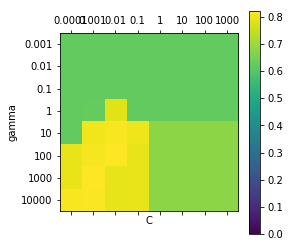

In [128]:
# make wide the ranges

param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=3, verbose=1)

# no meaning to use cross_val for grid_search model because it is incluced in grid search
#scores = cross_val_score(grid_search, X_train, y_train, cv=5, n_jobs=6)
#print("mean of train scores", scores.mean())

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(8, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['C'])), param_grid['C'])
plt.yticks(range(len(param_grid['gamma'])), param_grid['gamma'])
plt.colorbar()

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))

## KNeighborsClassifier

## try several SVC, KNeighborsClassifier models and preprocessing conbinations

----

# random forest result for compare

In [129]:
pipe = make_pipeline(RandomForestClassifier(max_depth=7, 
                                            max_features="auto",
                                            min_samples_leaf=1, 
                                            min_samples_split=3, 
                                            n_estimators=100))
pipe.fit(X_train, y_train)
print("test: ", pipe.score(X_test, y_test))

scores = cross_val_score(pipe, X_train_df, y_train_df, n_jobs=3)
print("mean of cross val score: ", scores.mean())

test:  0.827118644068
mean of cross val score:  0.828282828283


In [130]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(pipe.named_steps["randomforestclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
18,Title,0.238899
17,Sex,0.227569
16,Pclass,0.097440
19,FamilySize,0.084691
0,Age,0.067344
15,Fare,0.062499
13,Cabin_num_nan_category,0.051990
14,Embarked,0.041883
10,"Cabin_num_(1.999, 28.667]",0.020235
6,Cabin_Letter_E,0.018795


### try several scaling and feature selections for random forest

**try scaling for random forest**

**try feature selection**

## XGBoost

## AdaBoostClassifier

## GradientBoostingClassifier

In [136]:
#wide
"""param_grid = {'learning_rate': [0.001, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1],
              'n_estimators': [3, 5, 7, 10, 50, 100, 200, 500],
              'min_samples_split':[2, 3, 4, 5],
              'min_samples_leaf': [1, 2, 3, 4, 5],
              'max_depth':[1,2,3,4,5,6],
              'max_features': ['auto', 'sqrt', 'log2'],}
"""

# min
param_grid = {'learning_rate': [0.001, 0.005, 0.007, 0.01, 0.02, 0.05],
              'n_estimators': [3, 5, 7, 10, 50, 100, 200],
              'min_samples_split':[2, 3, 4, 5],
              'min_samples_leaf': [1, 2, 3, 5],
              'max_depth':[1,2,3,4,5,6],
              'max_features': ['auto', 'sqrt', 'log2'],}

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, n_jobs=3, verbose=1)
grid_search.fit(X_train, y_train)

"""
plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(6, -1),
            vmin=0, cmap="viridis")
plt.xlabel("n_estimators")
plt.ylabel("learning_rate")
plt.xticks(range(len(param_grid['n_estimators'])), param_grid['n_estimators'])
plt.yticks(range(len(param_grid['learning_rate'])), param_grid['learning_rate'])
plt.colorbar()
"""

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))

Fitting 5 folds for each of 12096 candidates, totalling 60480 fits


[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    3.5s
[Parallel(n_jobs=3)]: Done 1694 tasks      | elapsed:   16.0s
[Parallel(n_jobs=3)]: Done 4194 tasks      | elapsed:   50.5s
[Parallel(n_jobs=3)]: Done 6504 tasks      | elapsed:  1.6min
[Parallel(n_jobs=3)]: Done 8754 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done 11504 tasks      | elapsed:  3.8min
[Parallel(n_jobs=3)]: Done 14754 tasks      | elapsed:  4.5min
[Parallel(n_jobs=3)]: Done 18504 tasks      | elapsed:  6.1min
[Parallel(n_jobs=3)]: Done 22754 tasks      | elapsed:  7.5min
[Parallel(n_jobs=3)]: Done 27504 tasks      | elapsed:  9.2min
[Parallel(n_jobs=3)]: Done 32754 tasks      | elapsed: 11.1min
[Parallel(n_jobs=3)]: Done 38504 tasks      | elapsed: 13.1min
[Parallel(n_jobs=3)]: Done 47079 tasks      | elapsed: 16.0min
[Parallel(n_jobs=3)]: Done 55779 tasks      | elapsed: 18.9min
[Parallel(n_jobs=3)]: Done 60475 out of 60480 | elapsed: 21.0min remaining:    0.0s
[Parallel(n_jobs=3)]: Done 60480 out of 

best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Mean cross-validated score of the best_estimator:  0.845637583893
test:  0.837288135593


In [137]:
pipe = make_pipeline(GradientBoostingClassifier(learning_rate=0.01,
                                                max_depth=4,
                                                max_features="sqrt",
                                                min_samples_leaf=2,
                                                min_samples_split=5,
                                                n_estimators=200))
pipe.fit(X_train, y_train)
print("test: ", pipe.score(X_test, y_test))

scores = cross_val_score(pipe, X_train_df, y_train_df, n_jobs=3)
print("mean of cross val score for X_train_df: ", scores.mean())

test:  0.833898305085
mean of cross val score for X_train_df:  0.832772166105


In [138]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(pipe.named_steps["gradientboostingclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
18,Title,0.265103
17,Sex,0.233681
16,Pclass,0.115127
19,FamilySize,0.084211
0,Age,0.060461
15,Fare,0.043397
13,Cabin_num_nan_category,0.043286
14,Embarked,0.039469
6,Cabin_Letter_E,0.027275
10,"Cabin_num_(1.999, 28.667]",0.016824


In [139]:
pipe.fit(X_train_df, y_train_df)

test_df_noid = test_df.drop("PassengerId", axis=1).copy()
y_pred = pipe.predict(test_df_noid).astype(int)

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"].astype(int),
        "Survived": y_pred
    })
submission.to_csv('../output/submission_gradientboosting.csv', index=False)

In [140]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(pipe.named_steps["gradientboostingclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
18,Title,0.278140
17,Sex,0.226206
16,Pclass,0.112216
19,FamilySize,0.103962
0,Age,0.077115
13,Cabin_num_nan_category,0.057174
15,Fare,0.044871
14,Embarked,0.029050
10,"Cabin_num_(1.999, 28.667]",0.016268
6,Cabin_Letter_E,0.012870


### try scaling and feature selection

**try scaling for Gradient boosting**

**try feature selection**